# exp018

各record cnt を全record cntに対する比率に変更

In [68]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
@dataclass
class Cfg:
    mode = "local_cv" # "local_cv" or "kaggle_inf" 
    exp_name = "exp018"
    input_dir = "/mnt/predict-student-performance-from-game-play/input/"
    output_dir = "/mnt/predict-student-performance-from-game-play/output/"
    prep_dir = "/mnt/predict-student-performance-from-game-play/prep/"
    seed = 42
    n_splits = 5
    best_threshold = 0.620 # local_cvの結果を入れる
cfg = Cfg()

if cfg.mode == "local_cv":
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)

elif cfg.mode == "kaggle_inf":
    import jo_wilder

In [70]:
params = {
    'objective': 'binary', 
    'boosting': 'gbdt', 
    'learning_rate': 0.1, 
    'metric': 'binary_logloss', 
    'seed': cfg.seed, 
    'feature_pre_filter': False, 
    'lambda_l1': 3.86172588734434e-05, 
    'lambda_l2': 8.164200511365216, 
    'num_leaves': 31, 
    'feature_fraction': 0.4, 
    'bagging_fraction': 0.9437148886789388, 
    'bagging_freq': 1, 
    'min_child_samples': 50
}

In [71]:
event_name_list = [
    'cutscene_click', 'person_click', 'navigate_click',
    'observation_click', 'notification_click', 'object_click',
    'object_hover', 'map_hover', 'map_click', 'checkpoint',
    'notebook_click'
]

name_list = [
    'basic', 'undefined', 'close', 'open', 'prev', 'next'
]

In [72]:
def transform_labels_df(labels_):
    """
    labelsデータを整形する
    """
    labels = labels_.copy()
    labels["question"] = labels["session_id"].apply(lambda x: x.split("_")[1].replace("q", "")).astype(int)
    labels["session_id"] = labels["session_id"].apply(lambda x: x.split("_")[0]).astype(int)
    
    # trainの特徴量と結合するためにquestionに対応するlabel_groupを列として設けておく
    labels["level_group"] = ""
    labels.loc[labels["question"]<=3, "level_group"] = "0-4"
    labels.loc[(labels["question"]>=4)&(labels["question"]<=13), "level_group"] = "5-12"
    labels.loc[labels["question"]>=14, "level_group"] = "13-22"

    return labels

In [73]:
class Features:
    def __init__(self, sessions):
        self.sessions = sessions.copy()
        self.sessions = self.sessions.sort_values(["session_id", "level_group", "elapsed_time"], ignore_index=True)
        self.features = sessions[["session_id", "level_group"]].drop_duplicates().copy()

    def _lg_record_cnt(self):
        """level_groupごとのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":"lg_record_cnt"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _lg_event_name_record_ratio(self):
        """level_groupごと、各event_nameのレコード数が全レコード数に占める割合
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        add_features["ratio"] = add_features["cnt"] / add_features.groupby(["session_id", "level_group"])["cnt"].transform("sum")
        add_features = add_features.drop(columns=["cnt"])
        for event in event_name_list:
            new_col = f"lg_{event}_record_ratio"
            tmp = add_features[add_features["event_name"]==event][["session_id", "level_group", "ratio"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"ratio": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _lg_name_record_ratio(self):
        """level_groupごと、各nameのレコード数が全レコード数に占める割合
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        add_features["ratio"] = add_features["cnt"] / add_features.groupby(["session_id", "level_group"])["cnt"].transform("sum")
        add_features = add_features.drop(columns=["cnt"])
        for name in name_list:
            new_col = f"lg_{name}_record_ratio"
            tmp = add_features[add_features["name"]==name][["session_id", "level_group", "ratio"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"ratio": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _lg_elapsed_time(self):
        """level_groupごと、epapsed_timeのmax - min（経過時間）
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])["elapsed_time"].agg([max,min]).reset_index()
        add_features["lg_elapsed_time"] = add_features["max"] - add_features["min"]
        add_features = add_features[["session_id", "level_group", "lg_elapsed_time"]].copy()
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _lg_coor_mean(self):
        """level_groupごと、座標系の平均値
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])[["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]].mean().reset_index()
        add_features = add_features.rename(columns={"room_coor_x":"lg_room_coor_x_mean", "room_coor_y":"lg_room_coor_y_mean", "screen_coor_x":"lg_screen_coor_x_mean", "screen_coor_y":"lg_screen_coor_y_mean"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _lg_cat_col_nunique(self, col):
        """level_groupごと、[col]のユニーク数
        """
        add_features = self.sessions.dropna(subset=[col]).drop_duplicates(["session_id", "level_group", col])
        add_features = add_features.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":f"lg_{col}_nunique"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _elapsed_time_diff(self):
        """level_groupごと、前後のレコードのelapsed_timeの差分に関する集計量
        """
        add_features = self.sessions.copy()
        add_features["elapsed_time_diff"] = add_features["elapsed_time"] - add_features.groupby(["session_id", "level_group"])["elapsed_time"].shift(1)
        add_features = add_features.groupby(["session_id", "level_group"])["elapsed_time_diff"].agg(["max", "min", "mean", "std"]).reset_index()
        add_features = add_features.rename(columns={"max":"lg_elapsed_time_diff_max", "min":"lg_elapsed_time_diff_min", "mean":"lg_elapsed_time_diff_mean", "std":"lg_elapsed_time_diff_std"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def get_features(self):
        self._lg_record_cnt()
        self._lg_event_name_record_ratio()
        self._lg_name_record_ratio()
        self._lg_elapsed_time()
        self._lg_coor_mean()
        self._lg_cat_col_nunique("text")
        self._elapsed_time_diff()
        return self.features

In [74]:
def calc_metrics(oof):
    # find best th
    scores = []; thresholds = []
    best_score = 0; best_threshold = 0

    for threshold in np.arange(0.4,0.81,0.01):
        preds = (oof["pred"].values>threshold).astype(int)
        m = f1_score(oof["correct"].values, preds, average='macro')   
        scores.append(m)
        thresholds.append(threshold)
        if m>best_score:
            best_score = m
            best_threshold = threshold
    print("best_score", format(best_score, ".6f"))
    print("best_threshold", format(best_threshold, ".3f"))

    # Q別スコア
    print("---"*10)
    for q in range(18):
        q = q + 1
        preds = (oof[oof["question"]==q]["pred"].values>threshold).astype(int)
        m = f1_score(oof[oof["question"]==q]["correct"].values, preds, average='macro')
        print(f"Q{q} : F1 = {format(m, '.6f')}")
    return best_threshold

In [75]:
def get_train_data(sessions, labels):
    # labelデータの整形
    labels = transform_labels_df(labels)

    # 特徴量生成
    feat = Features(sessions)
    features = feat.get_features()
    
    train = features.merge(labels, on=["session_id", "level_group"], how="left")
    train["level_group"] = train["level_group"].map({"0-4":0, "5-12":1, "13-22":2}).astype("category")
    train["question"] = train["question"].astype("category")

    return train

In [76]:
def run_train():
    # データ読み込み
    train_sessions = pd.read_csv(cfg.input_dir + "train.csv")
    labels = pd.read_csv(cfg.input_dir + "train_labels.csv")
    
    train = get_train_data(train_sessions, labels)

    target = "correct"
    not_use_cols = [target, "session_id", "level_group"]
    features = [c for c in train.columns if c not in not_use_cols]

    gkf = GroupKFold(n_splits=cfg.n_splits)
    fis = []
    oofs = []
    for i, (tr_idx, vl_idx) in enumerate(gkf.split(train[features], train[target], train["session_id"])):
        print(f"fold : {i}")
        tr_x, tr_y = train.iloc[tr_idx][features], train.iloc[tr_idx][target]
        vl_x, vl_y = train.iloc[vl_idx][features], train.iloc[vl_idx][target]
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)
        # モデル出力
        model.save_model(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb")
        
        # valid_pred
        oof_fold = train.iloc[vl_idx].copy()
        oof_fold["pred"] = model.predict(vl_x, num_iteration=model.best_iteration)
        oofs.append(oof_fold)

        # 特徴量重要度
        fi_fold = pd.DataFrame()
        fi_fold["feature"] = model.feature_name()
        fi_fold["importance"] = model.feature_importance(importance_type="gain")
        fi_fold["fold"] = i
        fis.append(fi_fold)

    fi = pd.concat(fis)    
    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance")
    plt.tight_layout()
    plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance.png')

    # cv
    oof = pd.concat(oofs)
    best_threshold = calc_metrics(oof)
    cfg.best_threshold = best_threshold
    oof.to_csv(cfg.output_dir + f"{cfg.exp_name}/oof.csv.gz", compression="gzip", index=False)

In [77]:
def get_mock_iter_test():
    test = pd.read_csv(cfg.input_dir + "test.csv")
    sub = pd.read_csv(cfg.input_dir + "sample_submission.csv")
    tests = [df[1].drop(columns="session_level").reset_index(drop=True) for df in test.groupby("session_level")]
    subs = [df[1].drop(columns="session_level").reset_index(drop=True) for df in sub.groupby("session_level")]
    return zip(subs, tests)

In [78]:
def inference(mode):
    if mode == "local_cv":
        # time series apiを模したiterをモックとして用意する
        iter_test = get_mock_iter_test()
    elif mode == "kaggle_inf":
        env = jo_wilder.make_env()
        iter_test = env.iter_test()
        
    models = []
    for i in range(cfg.n_splits):
        if mode == "local_cv":
            model_path = cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb"
        elif mode == "kaggle_inf":
            model_path = f"/kaggle/input/jo-wilder-{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb"
        models.append(lgb.Booster(model_file=model_path))
    
    for (sample_submission, test_sessions) in iter_test:
        test = get_train_data(test_sessions, sample_submission)
        preds = np.zeros(len(test))
        for i in range(cfg.n_splits):
            model = models[i]
            features = model.feature_name()
            preds += model.predict(test[features], num_iteration=model.best_iteration) / cfg.n_splits
        preds = (preds>cfg.best_threshold).astype(int)
        sample_submission["correct"] = preds

        if mode == "local_cv":
            print(sample_submission["correct"].values)
        elif mode == "kaggle_inf":
            env.predict(sample_submission)

fold : 0


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 119434, number of negative: 50180
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7037
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704152 -> initscore=0.867147
[LightGBM] [Info] Start training from score 0.867147


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.488442	valid_1's binary_logloss: 0.497928
[200]	training's binary_logloss: 0.47555	valid_1's binary_logloss: 0.496871
[300]	training's binary_logloss: 0.465542	valid_1's binary_logloss: 0.497109
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.47358	valid_1's binary_logloss: 0.496838
fold : 1


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[LightGBM] [Info] Number of positive: 119268, number of negative: 50346
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7039
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703173 -> initscore=0.862454
[LightGBM] [Info] Start training from score 0.862454
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.487545	valid_1's binary_logloss: 0.502113
[200]	training's binary_logloss: 0.474277	valid_1's binary_logloss: 0.501211
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.475809	valid_1's binary_logloss: 0.501059
fold : 2
[LightGBM] [Info] Number of positive: 119502, number of negative: 50112


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7041
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704553 -> initscore=0.869073
[LightGBM] [Info] Start training from score 0.869073
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.486174	valid_1's binary_logloss: 0.506782
[200]	training's binary_logloss: 0.473058	valid_1's binary_logloss: 0.505859
[300]	training's binary_logloss: 0.462612	valid_1's binary_logloss: 0.505795
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.470345	valid_1's binary_logloss: 0.505732
fold : 3


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[LightGBM] [Info] Number of positive: 119476, number of negative: 50138
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7041
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704399 -> initscore=0.868336
[LightGBM] [Info] Start training from score 0.868336
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.487273	valid_1's binary_logloss: 0.502637
[200]	training's binary_logloss: 0.474084	valid_1's binary_logloss: 0.501587
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.474674	valid_1's binary_logloss: 0.501575
fold : 4
[LightGBM] [Info] Number of positive: 119328, number of negative: 50304


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7039
[LightGBM] [Info] Number of data points in the train set: 169632, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703452 -> initscore=0.863791
[LightGBM] [Info] Start training from score 0.863791
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.487062	valid_1's binary_logloss: 0.504243
[200]	training's binary_logloss: 0.473852	valid_1's binary_logloss: 0.503717
[300]	training's binary_logloss: 0.463646	valid_1's binary_logloss: 0.503892
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.470846	valid_1's binary_logloss: 0.503632
best_score 0.678533
best_threshold 0.620
------------------------------
Q1 : F1 = 0.537925
Q2 : F1 = 0.494

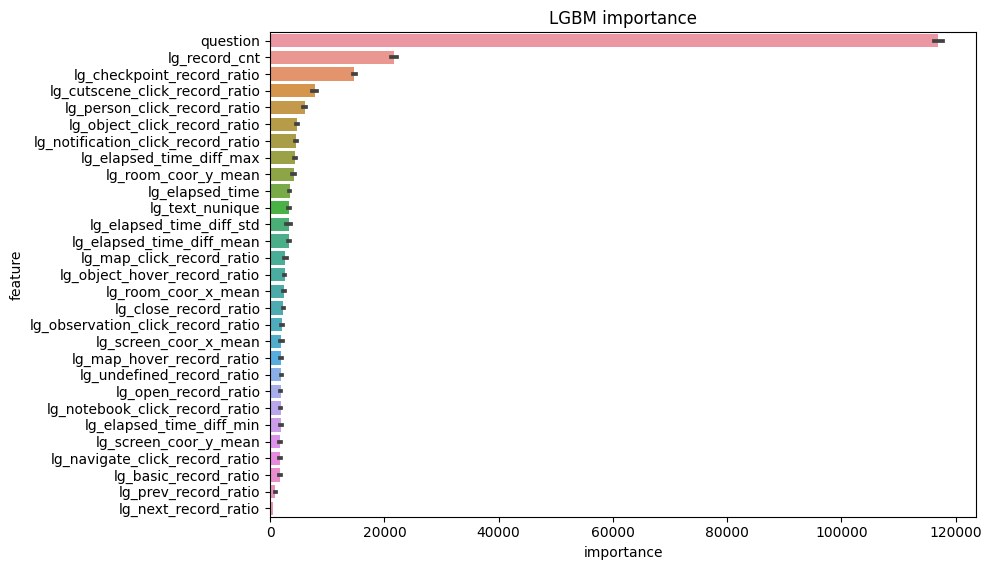

In [79]:
if cfg.mode == "local_cv":
    run_train()
#inference(cfg.mode)